# Forest Fire Recognition Project - 1st Part

First approach to the task, explained in the section 3 of the pdf report.

links for datasets used: 

1.   https://www.kaggle.com/phylake1337/fire-dataset
2.   https://data.mendeley.com/datasets/gjmr63rz2r/1







#Data, Libraries and Functions

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#Libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import datetime, os
from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!unrar x drive/MyDrive/combined.rar

In [49]:
H,W=160,160
BATCH_SIZE=32

In [50]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('./combined', shuffle=True, seed=42, image_size=(H, W),batch_size=1)

Found 2899 files belonging to 2 classes.


In [51]:
ds=dataset.unbatch()

In [52]:
DATASET_SIZE=2899

In [53]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)


train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset   = val_dataset.batch(BATCH_SIZE)
test_dataset  = test_dataset.batch(BATCH_SIZE)

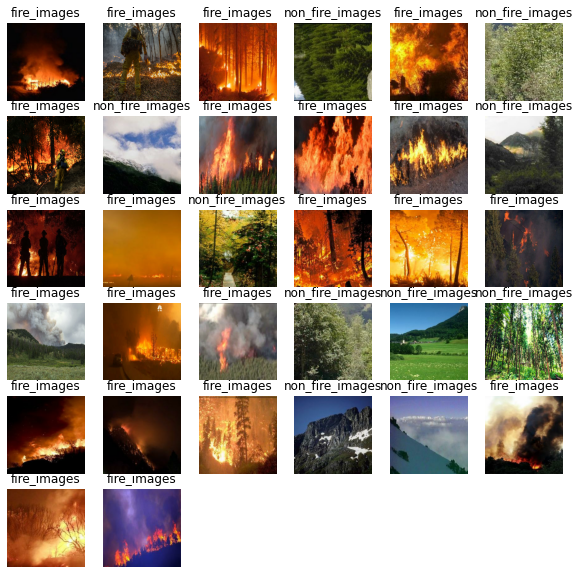

In [54]:
#Visualizing the data

plt.figure(figsize=(10, 10))
class_names = dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Functions

Here we have some functions to visualize metrics and evaluate the performances of our models.

In [55]:
#Print loss and accuracy wrt epochs
def plot_res(history):
  %matplotlib inline
  import matplotlib.pyplot as plt
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'g', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.legend(loc=0)
  plt.figure()
  plt.show()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'orange', label='Validation loss')
  plt.title('Training and validation loss')

  plt.legend(loc=0)
  plt.figure()
  plt.show()

In [56]:
def misclass(model,dataset):
  """
  Function returning the misclassified samples 


  TP: fires,     FP: not fires but fires
  TN: non fires, FN: fire but not fires
  """

  misclass=[]
  nofire_butfire=[]
  fire_butnotfire=[]
  predictions = []
  num_s=0
  TP=0
  for batch,labels in dataset:
    pred = model.predict(batch)
    for i in range(0,len(batch)):
      if num_s>489:
        break
      y_pred=pred[i]
      y_true=labels[i]
      if int(y_true) != tf.round(y_pred[0]):
        misclass.append([batch[i],y_true,y_pred])
        if int(y_true) == 1:
          nofire_butfire.append([batch[i][0],y_true,y_pred])
        else:
          fire_butnotfire.append([batch[i][0],y_true,y_pred])
      elif int(y_true) ==0: 
        TP+=1
      
      num_s+=1
    
  return misclass

In [57]:
def report(model,ds):
  predictions=[]
  true_values=[]
  num_b=0
  num_s=0
  for batch,labels in ds:
    batch_pred = model.predict(batch)
    
    for i in range(0,len(batch)):
      if num_s>489:
        break
      predictions.append(tf.round(batch_pred[i]))
      true_values.append(tf.round(labels[i]))
      num_s+=1

  print("\nReport:")
  print("\nF1_score:")
  print(f1_score(true_values,predictions))
  target_names = ['fire','not fire']
  print(classification_report(true_values,predictions,target_names=target_names))
  print("\nConfusion Matrix:")
  cm=confusion_matrix(true_values,predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

In [58]:
def visualize_errors(misclass):
  """
  Visualize the misclassified samples

  """
  i=0
  plt.figure(figsize=(10, 10))
  for x,y,z in misclass:
    ax = plt.subplot(len(misclass),1, i+1)
    plt.imshow(x.numpy().astype("uint8"))
    plt.title('True label '+str(int(y)) + ' but predicted ' + str(z[0]))
    plt.axis("off")
    i+=1
    #plt.show()

# Baseline

### Start

In [59]:
en = tf.keras.applications.EfficientNetB0(input_shape=(H, W, 3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [60]:
def build_model(net,augment=False,da_layer=None,dropout=.2):

  input_tensor = tf.keras.layers.Input(shape=(H, W, 3))

  if augment==True:
    x = da_layer(input_tensor)
  else:
    x = input_tensor

  if net.name[0] == 'm': #mobilenet preprocessing
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x=preprocess_input(x)
  elif net.name[0] == 'v': #vgg preprocessing
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    x=preprocess_input(x)
  
  base_model = net
  base_model.trainable = False #freezing the backbone

  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=input_tensor, outputs=predictions)

  return model


### EfficientNetB0

In [61]:
en_model = build_model(net=en,dropout=.2)

In [62]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [63]:
en_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_____________________________________________

In [64]:
en_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [66]:
en_history = en_model.fit(train_dataset,validation_data=val_dataset,epochs=75, callbacks=[es_callback])

Epoch 1/75
73/73 [==============================] - 83s 1s/step - loss: 0.3306 - accuracy: 0.8905 - val_loss: 0.1716 - val_accuracy: 0.9656
Epoch 2/75
73/73 [==============================] - 74s 1s/step - loss: 0.1315 - accuracy: 0.9711 - val_loss: 0.1262 - val_accuracy: 0.9725
Epoch 3/75
73/73 [==============================] - 76s 1s/step - loss: 0.0914 - accuracy: 0.9780 - val_loss: 0.1097 - val_accuracy: 0.9759
Epoch 4/75
73/73 [==============================] - 75s 1s/step - loss: 0.0792 - accuracy: 0.9806 - val_loss: 0.1009 - val_accuracy: 0.9759
Epoch 5/75
73/73 [==============================] - 75s 1s/step - loss: 0.0681 - accuracy: 0.9832 - val_loss: 0.0938 - val_accuracy: 0.9759
Epoch 6/75
73/73 [==============================] - 75s 1s/step - loss: 0.0590 - accuracy: 0.9828 - val_loss: 0.0898 - val_accuracy: 0.9794
Epoch 7/75
73/73 [==============================] - 77s 1s/step - loss: 0.0519 - accuracy: 0.9879 - val_loss: 0.0864 - val_accuracy: 0.9794
Epoch 8/75
73/73 [==

In [67]:
en_model.evaluate(test_dataset)

10/10 [==============================] - 17s 730ms/step - loss: 0.0240 - accuracy: 0.9965


[0.023958636447787285, 0.9965397715568542]

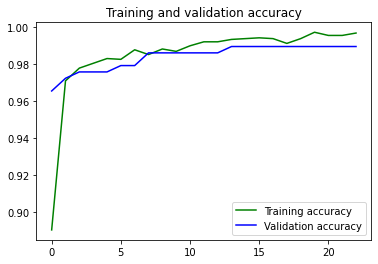

<Figure size 432x288 with 0 Axes>

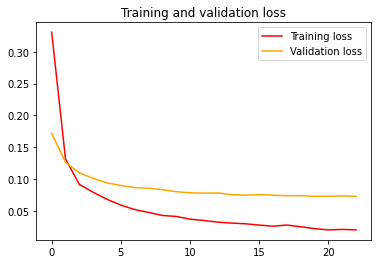

<Figure size 432x288 with 0 Axes>

In [68]:
plot_res(en_history)

In [69]:
en_err=misclass(en_model,test_dataset)

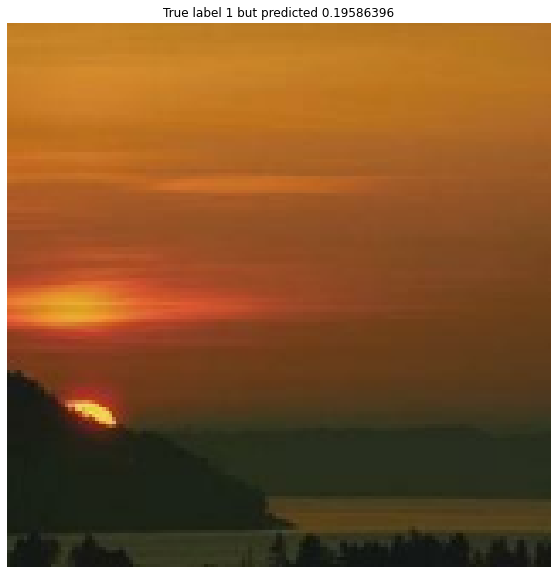

In [70]:
x=visualize_errors(en_err)

In [71]:
en_model.save('/content/drive/MyDrive/Foco_models/en_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Report:

F1_score:
0.9955947136563876
              precision    recall  f1-score   support

        fire       0.99      1.00      1.00       175
    not fire       1.00      0.99      1.00       114

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289


Confusion Matrix:


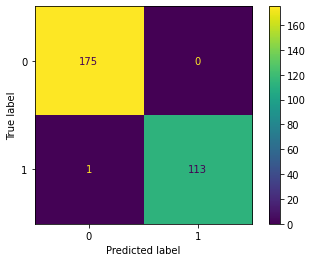

In [72]:
report(en_model,test_dataset)

There's a mistake in the dataset, one image is mislabelled!:

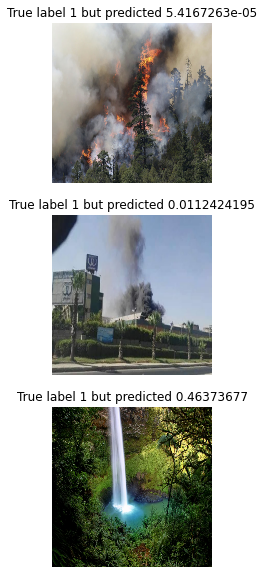

In [73]:
visualize_errors(misclass(en_model, val_dataset))

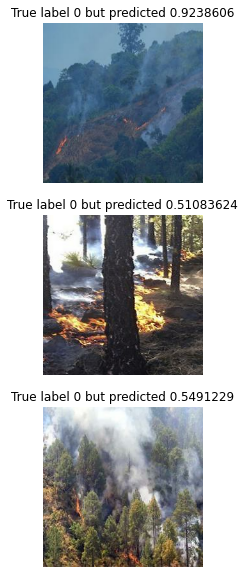

In [74]:
visualize_errors(misclass(en_model, train_dataset))

# Testing the baseline on the leadingIndiaAI dataset

Let's see if my model performs good wrt another model.

In [84]:
!git clone https://github.com/LeadingIndiaAI/Forest-Fire-Detection-through-UAV-imagery-using-CNNs
train_path='/content/Forest-Fire-Detection-through-UAV-imagery-using-CNNs/data/train'
val_path='/content/Forest-Fire-Detection-through-UAV-imagery-using-CNNs/data/validation'
train2 = tf.keras.preprocessing.image_dataset_from_directory(train_path, shuffle=True, seed=42, image_size=(H, W), batch_size=1)
val2 =  tf.keras.preprocessing.image_dataset_from_directory(val_path, shuffle=True, seed=42, image_size=(H, W), batch_size=1)

fatal: destination path 'Forest-Fire-Detection-through-UAV-imagery-using-CNNs' already exists and is not an empty directory.
Found 1914 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


In [85]:
en_model.evaluate(train2)
en_model.evaluate(val2)

182/182 [==============================] - 6s 35ms/step - loss: 0.1330 - accuracy: 0.9341


[0.13304367661476135, 0.9340659379959106]


Report:

F1_score:
0.9366053169734151
              precision    recall  f1-score   support

        fire       0.95      0.92      0.94       249
    not fire       0.92      0.95      0.94       241

    accuracy                           0.94       490
   macro avg       0.94      0.94      0.94       490
weighted avg       0.94      0.94      0.94       490


Confusion Matrix:


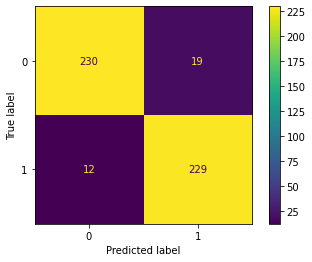

In [86]:
report(en_model,train2)


Report:

F1_score:
0.9268292682926829
              precision    recall  f1-score   support

        fire       0.96      0.92      0.94       102
    not fire       0.90      0.95      0.93        80

    accuracy                           0.93       182
   macro avg       0.93      0.94      0.93       182
weighted avg       0.94      0.93      0.93       182


Confusion Matrix:


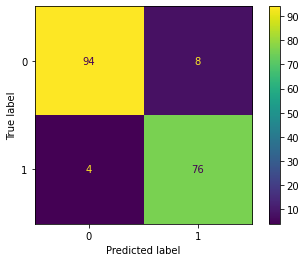

In [87]:
report(en_model,val2)

# Error Analysis

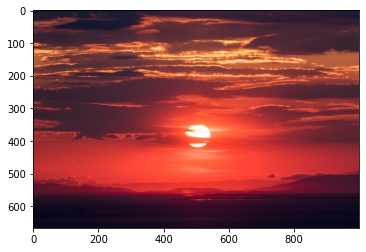

In [79]:
#let'see if the model fails in general with sunsets
import cv2

img = cv2.imread("/content/drive/MyDrive/sunset.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [80]:
res = cv2.resize(img_cvt, (H,W), interpolation=cv2.INTER_LINEAR)

In [81]:
res.shape

(160, 160, 3)

In [82]:
res = np.expand_dims(res, axis=0)

In [83]:
en_model.predict(res)[0]

array([0.00826734], dtype=float32)

As forecasted the system can be fooled easily by sunsets.